# Project 6: Airfoil Performance and Wing Design


In [49]:
# 1.1a
# Design conditions
s = 235 # ft2 wing area
c = 9 # ft chord length
b = 42.5 # ft span
Vcruise = 400 # mph
Vcruise = Vcruise*5280/3600 # ft/s
h = 21000 # ft geometric cruise altitude
w = 15000 # lbs loaded weight
mu = 3.25e-7 # slugs/fts dynamic viscosity at h
rho = 1.2249e-3 # slugs/ft3 air density at h

Re = rho * Vcruise * c / mu
Cl_cruise = 2*w/(c*rho*Vcruise**2)/32.2
print(f"Design Reynold's number: {Re:.2e}")
print(f"CL_cruise: {Cl_cruise:.3f}")
print(f"CL_2g: {Cl_cruise*2:.3f}")

Design Reynold's number: 1.99e+07
CL_cruise: 0.246
CL_2g: 0.491


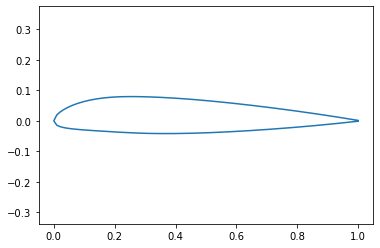

In [50]:
# Creating 24012 geometry with code from project 1
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

airfoil_name = '24012'
chord = 1

def airfoil_surface(airfoil, c):
    
    tau = ''.join(list(airfoil)[2:4]) # grab just the third and fourth digits from the NACA code
    t = int(tau)/100/c

    x = np.linspace(start=0, stop=1, num=101)
    x *= c # just in case chord is not 1
    # Given formula for symmetric airfoil surface points
    zt_c_upper = t/0.2*(0.2969*(x/c)**0.5 - 0.126*(x/c) - 0.3516*(x/c)**2 + 0.2843*(x/c)**3 - 0.1015*(x/c)**4) 
    zt_c_lower = -zt_c_upper # The lower surface is just the reflection of the upper surface
    camber = 0*x
    
    # output in following format: [[x], [top surface], [bottom surface], [camber]]
    return [x, zt_c_upper, zt_c_lower, camber]

def cambered_airfoil_5(foil, c):
    L = int(list(foil)[0])
    P = int(list(foil)[1])
    TT = int(''.join(list(foil)[3:5]))
    r = [0.058, 0.126, 0.2025, 0.29, 0.391]
    k1 = [361.400, 51.640, 15.957, 6.643, 3.230]
    x = np.linspace(start=0, stop=1, num=101)
    camber = np.zeros(len(x)) # set up the camber variable
    for i in range(len(camber)): # looping through to define each camber point based on given formula
        if x[i] < r[P-1]: # piecewise criteria
            camber[i] =  k1[P-1]/6*((x[i]**3) - (3*r[P-1]*x[i]**2)+(r[P-1])**2*(3-r[P-1])*x[i])# given formula for first piecewise section
        else:
            camber[i] =  k1[P-1]*r[P-1]**3/6*(1-x[i])# fiven formula for second piecewise section
    camber *= L/2
    # inputting thickness information into function created for problem 1.1 to get airfoil's outer geometry
    airfoil_geometry = airfoil_surface(f'00{TT}', c)
    zt_c_upper = np.add(camber, airfoil_geometry[1]) # using camber line to get airfoil surface because it's not symmetric
    zt_c_lower = np.add(camber, airfoil_geometry[2])
    return x, zt_c_upper, zt_c_lower

x, zt_c_upper, zt_c_lower = cambered_airfoil_5(airfoil_name, chord)
x = np.concatenate((np.flip(x), x))
z = np.concatenate((np.flip(zt_c_upper), zt_c_lower))
df = pd.DataFrame({'x': x, 'z': z})
df.to_csv('data/naca24012.dat', sep='\t', index=False)
        